# Exploratory Data Analysis of the Ocular Disease Recognition dataset

### What do I plan to do?
I want to take the inputs:
- Patient info (Age, Sex)
- Fundus imagery

and output a set of diagnostic keywords for their pathology

#### Imports

In [407]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [408]:
!pip install --quiet -e ../.

## DataFrame

In [409]:
#OcuPath
from OcuPath.dataframer import DataFramer

#DS
import sys
import os
import re
import math
import numpy as np
import pandas as pd

#EDA
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [410]:
# Instanciate class and read data
dataframer = DataFramer()
data = dataframer.read_data()
dataframer.test()

Diabetes (D)


In [411]:
# First and second round preparations of the dataframes
human_df = dataframer.get_human_df()
model_df = dataframer.get_model_df()

# Extract all keyphrases from Diagnostic
key_list = dataframer.get_key_list(model_df['Diagnostic Keywords'])

# To extract the jpg filename
left, right = dataframer.extract_jpg_names()

## Images

<strong>TODO</strong>:
- Clean ~400 rows from dataset where preprocessed images aren't present

In [612]:
# Need to work on developing the custom encoder below
# Boilerplate OHE
def has_keyword_mentioned(text, keyword='cataract'):
    if keyword in text:
        return '1'
    else:
        return '0'

In [613]:
import PIL.Image
import tensorflow as tf
import pathlib

# Set image path
dataframer.set_image_path()

# Used to binary encode Cataract labels only for now
model_df['Cataract'] = model_df['Diagnostic Keywords'].map(has_keyword_mentioned)

# Remove instances of missing images for data
true_images = os.listdir(dataframer.impath)
temp_df = model_df[model_df['Image'].isin(true_images)]

# Sort df based on alphameric image name
data_df = temp_df.sort_values(by=['Patient ID', 'Right Eye'])

In [614]:
data_df

,Patient Age,Patient Male,Image,Diagnostic Keywords,Right Eye,Cataract
Patient ID,,,,,,
0,69,0,0_left.jpg,cataract,0,1
0,69,0,0_right.jpg,normal fundus,1,0
1,57,1,1_left.jpg,normal fundus,0,0
1,57,1,1_right.jpg,normal fundus,1,0
2,42,1,2_right.jpg,moderate non proliferative retinopathy,1,0
...,...,...,...,...,...,...
4689,54,1,4689_right.jpg,normal fundus,1,0
4690,57,1,4690_left.jpg,mild nonproliferative retinopathy,0,0
4690,57,1,4690_right.jpg,mild nonproliferative retinopathy,1,0


In [616]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255.)

train_generator = datagen.flow_from_dataframe(
    dataframe=data_df,
    directory=pathlib.Path(dataframer.impath),
    x_col="Image",
    y_col="Cataract",
    batch_size=32,
    seed=42,
    shuffle=False,
    class_mode="binary",
    target_size=(512,512)
)

Found 6392 validated image filenames belonging to 2 classes.


In [645]:
train_generator[0][-1]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [607]:
# Method of batching using tf.keras.preprocessing.image_dataset_from_directory
# try pip install split-folders (tqdm)
k_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    pathlib.Path(dataframer.impath),
#     labels=None,
    labels=list(data_df.Cataract.values),
    label_mode='binary',
    image_size=(512, 512),
    shuffle=False
)

ValueError: Expected the lengths of `labels` to match the number of files in the target directory. len(labels) is 6392 while we found 0 files in ../raw_data/preprocessed_images.

In [568]:
data_df.reset_index().iloc[39:44]

,Patient ID,Patient Age,Patient Male,Image,Diagnostic Keywords,Right Eye,Cataract
39,23,47,1,23_left.jpg,hypertensive retinopathy,0,0
40,23,47,1,23_right.jpg,hypertensive retinopathy,1,0
41,24,75,0,24_left.jpg,normal fundus,0,0
42,24,75,0,24_right.jpg,cataract,1,1
43,25,63,1,25_left.jpg,normal fundus,0,0


In [579]:
# Method of batching using tf.data.Dataset.from_tensofr_slices
filenames = tf.constant(dataframer.impath+os.sep+temp_df['Image'].values)
labels = tf.constant(temp_df.Cataract)

dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))

def _parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)
    return image, label

dataset = dataset.map(_parse_function)
dataset = dataset.batch(32)

# step 4: create iterator and final input tensor
iterator = iter(dataset)
images, labels = iterator.get_next()

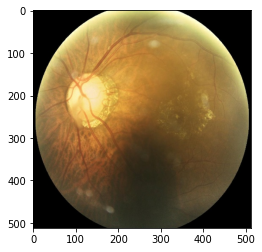

In [344]:
plt.imshow(np.array(images[6])/255)

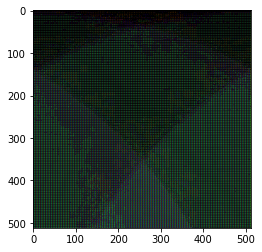

In [350]:
img = PIL.Image.fromarray(np.array(images[0]), 'RGB')
plt.imshow(img)

In [148]:
impath = os.path.join(dataframer.datapath, 'preprocessed_images')
data_dir = pathlib.Path(impath)
image_count = len(list(data_dir.glob('*.jpg')))
print(image_count)

6392


In [150]:
image = PIL.Image.open(f'../raw_data/preprocessed_images/{right[38]}')
width, height = image.size
width, height

(512, 512)

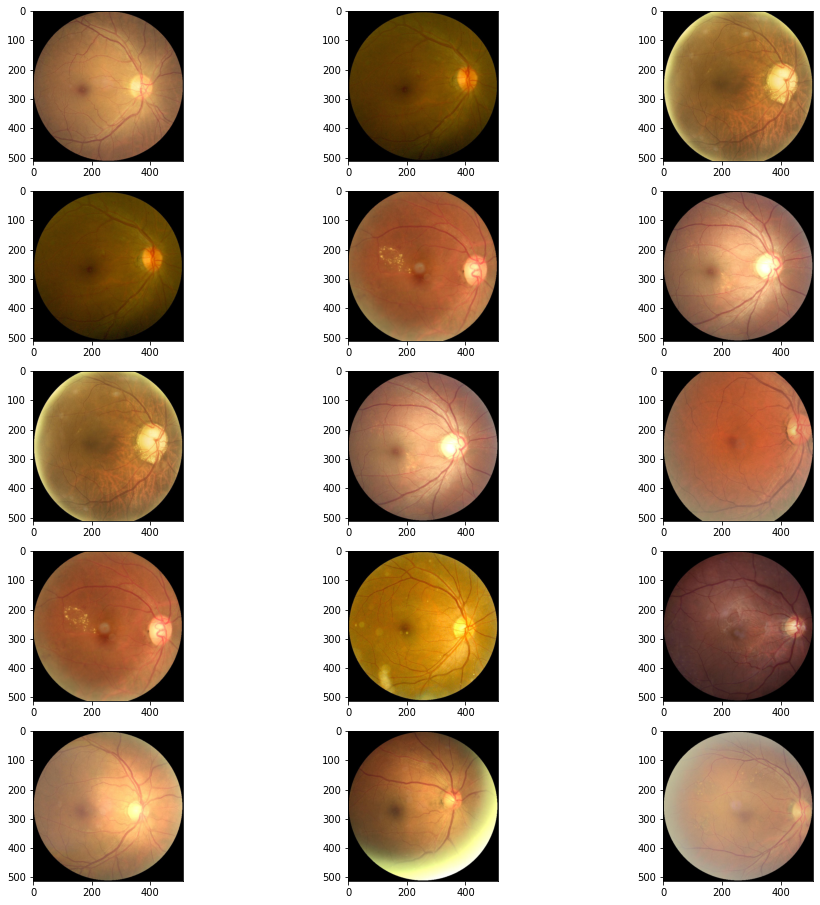

In [69]:
fig, axs = plt.subplots(5, 3, figsize=(16,16))

for i in range(5):
    for j in range(3):
        axs[i,j].imshow(plt.imread(f'../raw_data/preprocessed_images/{right[(i+1)*(j+1)]}'))